In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

This script assumes the following file structure:

./AXB.ipynb
./english/
./english/datafile1.csv
./english/datafile2.csv
./english/datafile3.csv
./english/etc
./panara/datafile1.csv
./panara/datafile2.csv
./panara/datafile3.csv
./panara/etc

First, read in all of the English speakers' data.  These data were collected through OpenSesame, which gives us a ton of variables we're not really interested in, so we'll also pare the columns down to just what we need, and also rename them.
Since we'll be joining this data with the Panara speakers' data, we'll want to be able to tell which subjects are Panara native speakers and which aren't, so we'll also add a new field for subject language.

In [2]:
engdir = os.path.abspath('./english/')
files = [f for f in os.listdir(engdir) if f[-4:]=='.csv']
responsedf_eng = pd.DataFrame()
for f in files:
    tdf = pd.read_csv(os.path.join(engdir,f))
    responsedf_eng = responsedf_eng.append(tdf)

In [3]:
responsedf_eng = responsedf_eng[['subject_nr','count_X','flip_order','stimA','stimX','stimB','response']]
responsedf_eng = responsedf_eng.rename(columns={"subject_nr":"subject", "count_X":"order", "stimA": "A", 
                                                "stimX":"X", "stimB":"B"})
responsedf_eng['language'] = 'non-Panara'
responsedf_eng.head()

,subject,order,flip_order,A,X,B,response,language
0,109,0,yes,4.1.2.wav,4.1.2.wav,4.1.4.wav,0,non-Panara
1,109,1,yes,1.1.1.wav,1.1.1.wav,1.1.3.wav,1,non-Panara
2,109,2,yes,4.2.2.wav,4.2.2.wav,4.2.4.wav,0,non-Panara
3,109,3,no,4.1.1.wav,4.1.3.wav,4.1.3.wav,0,non-Panara
4,109,4,yes,4.1.3.wav,4.1.3.wav,4.1.5.wav,0,non-Panara


The resulting dataframe has the following fields:
- subject: the subject's ID
- order: the order of stimulus presentation
- A, X, B: the files associated with A, X, and B; during setup, the time-step of A is _always_ less than that of B, and in order to vary this, we relied on a randomly generated variable flip_order
- flip_order: whether A and B were flipped during presentation; this is a fix for the problem of wanting to vary whether A or B has the higher step value, but having too many AXB sets to present subjects with the full factorial design
- response: subjects' response
- language: subjects' language category

Next, we'll do the same for the Panara speakers' data.  Here, we also have an additional field:
- repeats: the number of times the subject repeated each stimulus set before selecting their response

In [4]:
panaradir = os.path.abspath('./panara/')
files = [f for f in os.listdir(panaradir) if f[-4:]=='.csv']
responsedf_pan = pd.DataFrame()
for f in files:
    tdf = pd.read_csv(os.path.join(panaradir,f))
    responsedf_pan = responsedf_pan.append(tdf, sort=False)

In [5]:
responsedf_pan = responsedf_pan[['subject','order','repeats','flip_order','A','X','B','response']]
responsedf_pan['language']='Panara'
responsedf_pan.head()

,subject,order,repeats,flip_order,A,X,B,response,language
0,Pyjopen,0,3,1,3.2.1.wav,3.2.3.wav,3.2.3.wav,l,Panara
1,Pyjopen,1,1,1,1.2.3.wav,1.2.5.wav,1.2.5.wav,l,Panara
2,Pyjopen,2,1,1,4.2.2.wav,4.2.2.wav,4.2.4.wav,f,Panara
3,Pyjopen,3,1,1,4.1.1.wav,4.1.1.wav,4.1.3.wav,l,Panara
4,Pyjopen,4,1,1,3.2.2.wav,3.2.2.wav,3.2.4.wav,f,Panara


We'll join the data together, but we should note from above two fields that differ in encoding between the data sets:
- response: for English speakers, we expected responses of 1 or 0, corresponding to "the middle matches the first" and "the middle matches the last" respectively, but for Panara speakers we expected 'f' or 'l' instead.
- flip_order: in the English data, these are "yes" and "no", but in the Panara data, these are "1" and "0" respectively.

In [6]:
responsedf = pd.concat([responsedf_eng,responsedf_pan],sort=False)

One problem we encounter early on is that not all responses match the expected responses.  So we'll repair this by making some reasonable guesses as to what the subjects _intended_ when they responded.

In [7]:
responsedf.response.unique()

array([0, 1, 2, 3, '0', '1', 'right', '`', 'l', 'f', 'e', nan, 'd', 'ff',
       '3'], dtype=object)

In [8]:
responsedf.response = responsedf.response.apply(lambda x: 'f' if x in ['e','d','ff'] else x)
# This response occurs specifically in one Panara subject's data, where '3' seems to have replaced 'l', as all other
# responses in this subject's data are 'f'
responsedf.response = responsedf.response.apply(lambda x: 'l' if x=='3' else x) 
responsedf.response = responsedf.response.apply(lambda x: 1 if x in [2,3,'1','`'] else x)
responsedf.response = responsedf.response.apply(lambda x: 0 if x in ['0','right'] else x)
responsedf = responsedf[~responsedf.response.isna()]
responsedf.response.unique()

array([0, 1, 'l', 'f'], dtype=object)

A couple more little fixes to make the data consistent.

In [9]:
responsedf['order']=responsedf['order']+1
responsedf.response = responsedf.response.apply(lambda x: 1 if x=='f' else (0 if x=='l' else x))
responsedf.flip_order = responsedf.flip_order.apply(lambda x: 'yes' if x==1 else ('no' if x==0 else x))
responsedf.head()

,subject,order,flip_order,A,X,B,response,language,repeats
0,109,1,yes,4.1.2.wav,4.1.2.wav,4.1.4.wav,0,non-Panara,NaN
1,109,2,yes,1.1.1.wav,1.1.1.wav,1.1.3.wav,1,non-Panara,NaN
2,109,3,yes,4.2.2.wav,4.2.2.wav,4.2.4.wav,0,non-Panara,NaN
3,109,4,no,4.1.1.wav,4.1.3.wav,4.1.3.wav,0,non-Panara,NaN
4,109,5,yes,4.1.3.wav,4.1.3.wav,4.1.5.wav,0,non-Panara,NaN


We know that a few Panara speakers didn't actually complete the study, so let's find those subjects and remove them from the data.

In [10]:
incompletes = [s for s in responsedf.subject.unique() if len(responsedf[responsedf.subject==s])<198]
responsedf = responsedf[~responsedf.subject.isin(incompletes)]
incompletes

['Papyri', 'Saaso', 'Nokrea', 'Tunpo', 'Sokkree']

We also observed that some Panara speakers didn't appear to understand the task.  In particular, we noticed that some subjects routinely responded with alternating responses, and others responded with a streak of the same response.  Both cases suggest to us that the subjects were participating in the task because they wished to be part of the study, but didn't truly understand what they were being asked to do.  The next several cells tries to locate these subjects (in both the Panara and non-Panara speaking groups) and remove them from the data.

First, we'll define three functions, each of which creates a new column in a given dataframe.
- streak1 and streak0: for each row, it returns the number of 0s or 1s in a row that the subject responded with.
- altstreak: for each row, returns the number of alternating 0/1 responses in a row that the subject responded with.

In [11]:
def streak1(x):
    x['streak1'] = x.groupby((x['response'] != 1).cumsum()).cumcount() + ((x['response'] != 1).cumsum() == 0).astype(int) 
    return x

def streak0(x):
    x['streak0'] = x.groupby((x['response'] != 0).cumsum()).cumcount() + ((x['response'] != 0).cumsum() == 0).astype(int) 
    return x

def altstreak(x):
    x['streakalt'] = x.groupby((x['streak'] != 1).cumsum()).cumcount() + ((x['streak'] != 1).cumsum() == 0).astype(int) 
    return x

In [12]:
responsedf = responsedf.groupby('subject', sort=False).apply(streak1)
responsedf = responsedf.groupby('subject', sort=False).apply(streak0)
responsedf['streak'] = responsedf.streak1+responsedf.streak0
responsedf = responsedf.groupby('subject', sort=False).apply(altstreak)
responsedf.head(10)

,subject,order,flip_order,A,X,B,response,language,repeats,streak1,streak0,streak,streakalt
0,109,1,yes,4.1.2.wav,4.1.2.wav,4.1.4.wav,0,non-Panara,NaN,0,1,1,1
1,109,2,yes,1.1.1.wav,1.1.1.wav,1.1.3.wav,1,non-Panara,NaN,1,0,1,2
2,109,3,yes,4.2.2.wav,4.2.2.wav,4.2.4.wav,0,non-Panara,NaN,0,1,1,3
3,109,4,no,4.1.1.wav,4.1.3.wav,4.1.3.wav,0,non-Panara,NaN,0,2,2,0
4,109,5,yes,4.1.3.wav,4.1.3.wav,4.1.5.wav,0,non-Panara,NaN,0,3,3,0
5,109,6,no,1.1.3.wav,1.1.5.wav,1.1.5.wav,1,non-Panara,NaN,1,0,1,1
6,109,7,yes,2.2.2.wav,2.2.4.wav,2.2.4.wav,1,non-Panara,NaN,2,0,2,0
7,109,8,yes,3.1.3.wav,3.1.5.wav,3.1.5.wav,1,non-Panara,NaN,3,0,3,0
8,109,9,no,4.2.1.wav,4.2.1.wav,4.2.3.wav,1,non-Panara,NaN,4,0,4,0
9,109,10,yes,3.1.2.wav,3.1.4.wav,3.1.4.wav,0,non-Panara,NaN,0,1,1,1


Now, let's find the maximum streak of either 1s or 0s as well as the maximum alternating streak for each subject.
When we plot these two values against each other, we see that the vast majority of our subjects cluster together, but a handful of Panara speaking subjects are clear outliers.  In particular, it appears that a cutoff of either 25 (less generous) or 50 (more generous) for both plain streaks and alternating streaks should handle all of these outliers.

In [13]:
maxstreaks = responsedf.groupby(['subject'], as_index=False).aggregate(np.max)

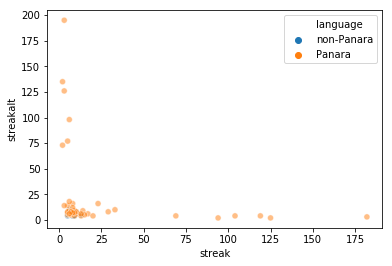

In [14]:
ax = sns.scatterplot('streak', 'streakalt', data=maxstreaks, hue='language', alpha=.5)
fig = ax.get_figure()
fig.savefig('ABX_error1.pdf')

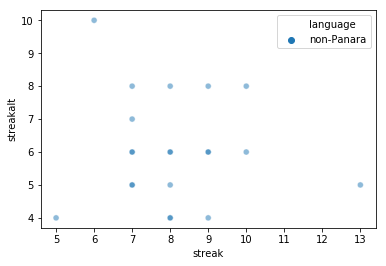

In [15]:
ax = sns.scatterplot('streak', 'streakalt', data=maxstreaks[maxstreaks.language=='non-Panara'], hue='language', alpha=.5)
fig = ax.get_figure()
fig.savefig('ABX_error2.pdf')

Armed with this information, we can now restrict our data to only those subjects who we expect did attend to the task as we intended.

In [16]:
maxstreaks['valid'] = maxstreaks.apply(lambda x: x.streak < 50 and x.streakalt < 50, axis=1)
valid = maxstreaks[maxstreaks.valid].subject.unique()
valid

array([102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 701, 702, 703, 704, 705, 'Josin', 'Jotikja',
       'Kankoo', 'Kape', 'Kapitao', 'Karo', 'Kasso', 'Kjepokjyn',
       'Kjepopo', 'Kokwari', 'Kopyn', 'Krekjon', 'Kuka', 'Kwankoren',
       'Kypakja', 'Mikre', 'Paasora', 'Pakrekaka', 'Paryti', 'Passi',
       'Patty', 'Peamiri', 'Pokjati', 'Prinkre', 'Pritty', 'Pukjora',
       'Pyjopen', 'Saankora', 'Sakjera', 'Sakjykjy', 'Seewa', 'Seppu',
       'Tenko', 'Tenko2', 'Tepakriti', 'Tepipjo', 'Tetata',
       'Twaturanpjuu'], dtype=object)

In [17]:
responsedf = responsedf[responsedf.subject.isin(valid)]

In [18]:
responsedf['response_AB'] = responsedf.apply(lambda x: 'A' if (x.response==1 and x.flip_order=='no') 
                                             or (x.response==0 and x.flip_order=='yes') 
                                             else 'B', axis=1)

In [19]:
responsedf['change_vowel'] = responsedf.apply(lambda x: False if (x.A[0] in ['1','2'] and x.B[0] in ['1','2'])
                                              or (x.A[0] in ['3','4'] and x.B[0] in ['3','4'])
                                              or (x.A[0]==x.B[0])
                                              else True, axis=1)
responsedf['change_nsource'] = responsedf.apply(lambda x: False if (x.A[0] in ['1','3'] and x.B[0] in ['1','3'])
                                              or (x.A[0] in ['2','4'] and x.B[0] in ['2','4'])
                                              or (x.A[0]==x.B[0])
                                              else True, axis=1)
responsedf['change_burst'] = responsedf.apply(lambda x: x.A[2]!=x.B[2], axis=1)
responsedf.head()

,subject,order,flip_order,A,X,B,response,language,repeats,streak1,streak0,streak,streakalt,response_AB,change_vowel,change_nsource,change_burst
0,109,1,yes,4.1.2.wav,4.1.2.wav,4.1.4.wav,0,non-Panara,NaN,0,1,1,1,A,False,False,False
1,109,2,yes,1.1.1.wav,1.1.1.wav,1.1.3.wav,1,non-Panara,NaN,1,0,1,2,B,False,False,False
2,109,3,yes,4.2.2.wav,4.2.2.wav,4.2.4.wav,0,non-Panara,NaN,0,1,1,3,A,False,False,False
3,109,4,no,4.1.1.wav,4.1.3.wav,4.1.3.wav,0,non-Panara,NaN,0,2,2,0,B,False,False,False
4,109,5,yes,4.1.3.wav,4.1.3.wav,4.1.5.wav,0,non-Panara,NaN,0,3,3,0,A,False,False,False


In [20]:
responsedf['same_spectral']=responsedf.apply(lambda x: '' if not (x.change_vowel or x.change_nsource or x.change_burst)
                 else ('A' if x.A[0:3]==x.X[0:3] else 'B'), axis=1)
responsedf['same_temporal']=responsedf.apply(lambda x: 'A' if x.A[4]==x.X[4] else 'B', axis=1)
responsedf.head()

,subject,order,flip_order,A,X,B,response,language,repeats,streak1,streak0,streak,streakalt,response_AB,change_vowel,change_nsource,change_burst,same_spectral,same_temporal
0,109,1,yes,4.1.2.wav,4.1.2.wav,4.1.4.wav,0,non-Panara,NaN,0,1,1,1,A,False,False,False,,A
1,109,2,yes,1.1.1.wav,1.1.1.wav,1.1.3.wav,1,non-Panara,NaN,1,0,1,2,B,False,False,False,,A
2,109,3,yes,4.2.2.wav,4.2.2.wav,4.2.4.wav,0,non-Panara,NaN,0,1,1,3,A,False,False,False,,A
3,109,4,no,4.1.1.wav,4.1.3.wav,4.1.3.wav,0,non-Panara,NaN,0,2,2,0,B,False,False,False,,B
4,109,5,yes,4.1.3.wav,4.1.3.wav,4.1.5.wav,0,non-Panara,NaN,0,3,3,0,A,False,False,False,,A


In [21]:
responsedf['match_temporal'] = responsedf.apply(lambda x: 1 if x.same_temporal==x.response_AB else 0, axis=1)
responsedf['match_spectral'] = responsedf.apply(lambda x: 1 if x.same_spectral==x.response_AB else 0, axis=1)
responsedf.head()

,subject,order,flip_order,A,X,B,response,language,repeats,streak1,...,streak,streakalt,response_AB,change_vowel,change_nsource,change_burst,same_spectral,same_temporal,match_temporal,match_spectral
0,109,1,yes,4.1.2.wav,4.1.2.wav,4.1.4.wav,0,non-Panara,NaN,0,...,1,1,A,False,False,False,,A,1,0
1,109,2,yes,1.1.1.wav,1.1.1.wav,1.1.3.wav,1,non-Panara,NaN,1,...,1,2,B,False,False,False,,A,0,0
2,109,3,yes,4.2.2.wav,4.2.2.wav,4.2.4.wav,0,non-Panara,NaN,0,...,1,3,A,False,False,False,,A,1,0
3,109,4,no,4.1.1.wav,4.1.3.wav,4.1.3.wav,0,non-Panara,NaN,0,...,2,0,B,False,False,False,,B,1,0
4,109,5,yes,4.1.3.wav,4.1.3.wav,4.1.5.wav,0,non-Panara,NaN,0,...,3,0,A,False,False,False,,A,1,0


In [22]:
responsedf['A_time'] = responsedf.A.apply(lambda x: x[4])
responsedf['A_burst'] = responsedf.A.apply(lambda x: True if x[2] == '1' else False)
responsedf.head()

,subject,order,flip_order,A,X,B,response,language,repeats,streak1,...,response_AB,change_vowel,change_nsource,change_burst,same_spectral,same_temporal,match_temporal,match_spectral,A_time,A_burst
0,109,1,yes,4.1.2.wav,4.1.2.wav,4.1.4.wav,0,non-Panara,NaN,0,...,A,False,False,False,,A,1,0,2,True
1,109,2,yes,1.1.1.wav,1.1.1.wav,1.1.3.wav,1,non-Panara,NaN,1,...,B,False,False,False,,A,0,0,1,True
2,109,3,yes,4.2.2.wav,4.2.2.wav,4.2.4.wav,0,non-Panara,NaN,0,...,A,False,False,False,,A,1,0,2,False
3,109,4,no,4.1.1.wav,4.1.3.wav,4.1.3.wav,0,non-Panara,NaN,0,...,B,False,False,False,,B,1,0,1,True
4,109,5,yes,4.1.3.wav,4.1.3.wav,4.1.5.wav,0,non-Panara,NaN,0,...,A,False,False,False,,A,1,0,3,True


In [23]:
plaindf=responsedf[responsedf.same_spectral=='']
plaindf['series']=plaindf.A.apply(lambda x: x[0])
plain_agg = plaindf.groupby(['subject','language','series','A_time', 'A_burst'],as_index=False).aggregate(np.mean)
plain_agg.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,subject,language,series,A_time,A_burst,order,response,repeats,streak1,streak0,streak,streakalt,change_vowel,change_nsource,change_burst,match_temporal,match_spectral
0,102,non-Panara,1,1,False,24.5,0.0,NaN,0.0,1.5,1.5,1.0,False,False,False,0.5,0.0
1,102,non-Panara,1,1,True,24.5,0.5,NaN,1.0,1.0,2.0,0.0,False,False,False,0.5,0.0
2,102,non-Panara,1,2,False,24.0,0.5,NaN,1.5,1.0,2.5,0.0,False,False,False,1.0,0.0
3,102,non-Panara,1,2,True,34.5,0.0,NaN,0.0,2.5,2.5,0.0,False,False,False,1.0,0.0
4,102,non-Panara,1,3,False,29.0,0.0,NaN,0.0,2.5,2.5,1.0,False,False,False,0.5,0.0


In [24]:
plain_agg.groupby(['subject'],as_index=False).aggregate(np.mean)

,subject,A_burst,order,response,repeats,streak1,streak0,streak,streakalt,change_vowel,change_nsource,change_burst,match_temporal,match_spectral
0,102,0.444444,27.5,0.500000,NaN,0.944444,1.037037,1.981481,0.703704,0.0,0.0,0.0,0.685185,0.0
1,103,0.444444,27.5,0.444444,NaN,0.851852,1.185185,2.037037,1.055556,0.0,0.0,0.0,0.814815,0.0
2,104,0.444444,27.5,0.500000,NaN,0.870370,0.870370,1.740741,0.740741,0.0,0.0,0.0,0.611111,0.0
3,105,0.444444,27.5,0.574074,NaN,1.425926,0.851852,2.277778,0.592593,0.0,0.0,0.0,0.814815,0.0
4,106,0.444444,27.5,0.407407,NaN,0.666667,1.259259,1.925926,1.037037,0.0,0.0,0.0,0.796296,0.0
5,107,0.444444,27.5,0.592593,NaN,1.148148,0.703704,1.851852,0.814815,0.0,0.0,0.0,0.666667,0.0
6,108,0.444444,27.5,0.574074,NaN,0.851852,0.555556,1.407407,1.962963,0.0,0.0,0.0,0.685185,0.0
7,109,0.444444,27.5,0.537037,NaN,1.259259,0.777778,2.037037,1.148148,0.0,0.0,0.0,0.592593,0.0
8,110,0.444444,27.5,0.555556,NaN,1.185185,0.666667,1.851852,0.888889,0.0,0.0,0.0,0.870370,0.0
9,111,0.444444,27.5,0.648148,NaN,1.444444,0.462963,1.907407,1.481481,0.0,0.0,0.0,0.629630,0.0


In [25]:
plain_agg.groupby(['series','A_time'],as_index=False).aggregate(np.mean)

,series,A_time,A_burst,order,response,repeats,streak1,streak0,streak,streakalt,change_vowel,change_nsource,change_burst,match_temporal,match_spectral
0,1,1,0.5,26.245763,0.546610,1.269737,1.449153,0.872881,2.322034,1.343220,0.0,0.0,0.0,0.597458,0.0
1,1,2,0.5,29.258475,0.538136,1.342105,1.436441,0.817797,2.254237,1.156780,0.0,0.0,0.0,0.677966,0.0
2,1,3,0.5,26.766949,0.555085,1.328947,1.322034,0.881356,2.203390,1.063559,0.0,0.0,0.0,0.648305,0.0
3,2,1,0.5,29.190678,0.521186,1.322368,1.542373,0.881356,2.423729,1.135593,0.0,0.0,0.0,0.703390,0.0
4,2,2,0.5,26.805085,0.538136,1.302632,1.411017,0.860169,2.271186,0.923729,0.0,0.0,0.0,0.750000,0.0
5,2,3,0.5,28.169492,0.508475,1.289474,1.504237,1.038136,2.542373,1.050847,0.0,0.0,0.0,0.733051,0.0
6,3,1,0.5,28.288136,0.546610,1.263158,1.245763,0.936441,2.182203,1.114407,0.0,0.0,0.0,0.614407,0.0
7,3,2,0.5,26.970339,0.516949,1.388158,1.389831,0.944915,2.334746,1.144068,0.0,0.0,0.0,0.652542,0.0
8,3,3,0.5,28.411017,0.538136,1.440789,1.283898,0.834746,2.118644,1.144068,0.0,0.0,0.0,0.580508,0.0
9,4,1,0.5,27.233051,0.567797,1.269737,1.322034,0.834746,2.156780,1.394068,0.0,0.0,0.0,0.656780,0.0


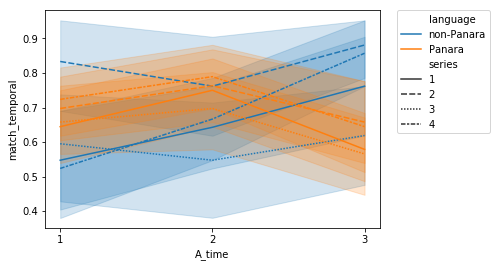

In [26]:
sns.lineplot(x='A_time',y='match_temporal',hue='language',style='series',data=plain_agg[plain_agg.A_burst])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


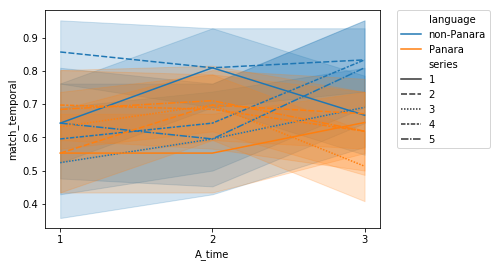

In [27]:
sns.lineplot(x='A_time',y='match_temporal',hue='language',style='series',data=plain_agg[plain_agg.A_burst==False])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [28]:
varydf=responsedf[responsedf.same_spectral!='']
vary_agg=varydf.groupby(['subject','language','change_vowel','change_nsource','change_burst','A_time','A_burst'],
                        as_index=False).aggregate(np.mean)

In [29]:
varydf.groupby(['language','change_vowel','change_nsource','change_burst','A_burst'],as_index=False).aggregate(np.mean)

,language,change_vowel,change_nsource,change_burst,A_burst,order,response,repeats,streak1,streak0,streak,streakalt,match_temporal,match_spectral
0,Panara,False,False,True,False,125.679825,0.509868,1.258772,1.063596,1.025219,2.088816,1.125000,0.591009,0.408991
1,Panara,False,False,True,True,128.003289,0.531798,1.266447,1.064693,1.061404,2.126096,1.207237,0.587719,0.412281
2,Panara,False,True,False,False,127.291667,0.475877,1.286184,1.017544,1.060307,2.077851,1.228070,0.513158,0.486842
3,Panara,False,True,False,True,129.088816,0.496711,1.290570,1.007675,1.114035,2.121711,1.258772,0.537281,0.462719
4,Panara,True,False,False,False,124.337719,0.507675,1.287281,1.030702,1.144737,2.175439,1.218202,0.263158,0.736842
5,Panara,True,False,False,True,124.598684,0.514254,1.293860,1.047149,1.095395,2.142544,1.217105,0.276316,0.723684
6,non-Panara,False,False,True,False,125.123016,0.492063,NaN,1.079365,0.996032,2.075397,0.892857,0.626984,0.373016
7,non-Panara,False,False,True,True,127.323413,0.496032,NaN,0.980159,1.049603,2.029762,0.944444,0.628968,0.371032
8,non-Panara,False,True,False,False,126.964286,0.492063,NaN,0.986111,0.996032,1.982143,0.946429,0.353175,0.646825
9,non-Panara,False,True,False,True,125.148810,0.507937,NaN,0.982143,0.976190,1.958333,0.900794,0.412698,0.587302


In [30]:
vary_agg['change'] = vary_agg.apply(lambda x: 'vowel' if x.change_vowel else ('nsource' if x.change_nsource else 'burst'), axis=1)

In [31]:
vary_agg.groupby(['change','subject','language'],as_index=False).aggregate(np.mean)

,change,subject,language,change_vowel,change_nsource,change_burst,A_burst,order,response,repeats,streak1,streak0,streak,streakalt,match_temporal,match_spectral
0,burst,102,non-Panara,0.0,0.0,1.0,0.5,126.687500,0.541667,NaN,1.041667,1.062500,2.104167,1.375000,0.458333,0.541667
1,burst,103,non-Panara,0.0,0.0,1.0,0.5,128.583333,0.312500,NaN,0.458333,1.583333,2.041667,0.916667,0.604167,0.395833
2,burst,104,non-Panara,0.0,0.0,1.0,0.5,119.958333,0.562500,NaN,0.791667,0.666667,1.458333,1.104167,0.500000,0.500000
3,burst,105,non-Panara,0.0,0.0,1.0,0.5,122.458333,0.437500,NaN,0.812500,1.104167,1.916667,0.833333,0.645833,0.354167
4,burst,106,non-Panara,0.0,0.0,1.0,0.5,124.750000,0.416667,NaN,0.791667,1.000000,1.791667,0.770833,0.708333,0.291667
5,burst,107,non-Panara,0.0,0.0,1.0,0.5,122.687500,0.437500,NaN,1.020833,1.083333,2.104167,0.937500,0.770833,0.229167
6,burst,108,non-Panara,0.0,0.0,1.0,0.5,131.125000,0.604167,NaN,1.125000,0.645833,1.770833,1.416667,0.541667,0.458333
7,burst,109,non-Panara,0.0,0.0,1.0,0.5,122.708333,0.520833,NaN,1.375000,1.166667,2.541667,0.833333,0.729167,0.270833
8,burst,110,non-Panara,0.0,0.0,1.0,0.5,131.104167,0.395833,NaN,0.854167,1.270833,2.125000,1.000000,0.583333,0.416667
9,burst,111,non-Panara,0.0,0.0,1.0,0.5,132.562500,0.583333,NaN,1.625000,1.020833,2.645833,0.583333,0.875000,0.125000


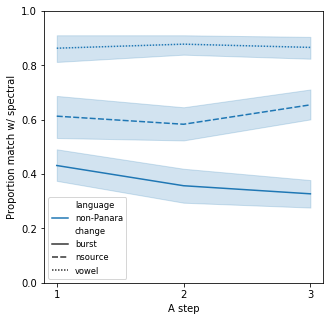

In [32]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.lineplot(x='A_time',y='match_spectral',hue='language',style='change',data=vary_agg[vary_agg.language=='non-Panara'])
ax.axes.set(ylabel='Proportion match w/ spectral', xlabel="A step",ylim=[0,1])
ax.legend(fontsize='small')
fig = ax.get_figure()
fig.savefig('ABX2a.pdf')

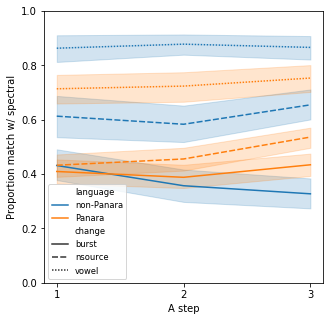

In [33]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.lineplot(x='A_time',y='match_spectral',hue='language',style='change',data=vary_agg)
ax.axes.set(ylabel='Proportion match w/ spectral', xlabel="A step",ylim=[0,1])
ax.legend(fontsize='small')
fig = ax.get_figure()
fig.savefig('ABX2.pdf')

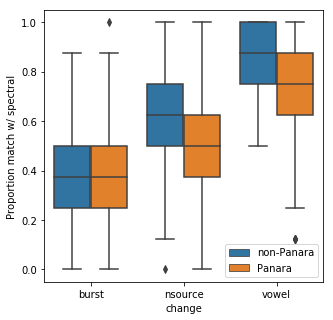

In [34]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.boxplot(x='change',y='match_spectral',hue='language',data=vary_agg)
ax.axes.set(ylabel='Proportion match w/ spectral')
ax.legend(loc='lower right')
fig = ax.get_figure()
fig.savefig('ABX2_box.pdf')

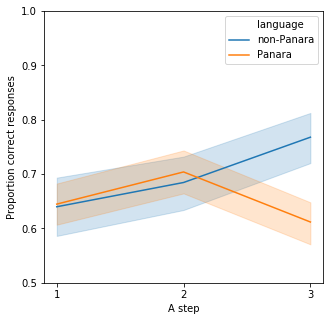

In [35]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.lineplot(x='A_time',y='match_temporal',hue='language',data=plain_agg[plain_agg.series!='5'])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axes.set(ylabel='Proportion correct responses', xlabel="A step",ylim=[0.5,1])
# sns.lineplot(x='A_time',y='match_temporal',hue='language',style='series',data=plain_agg[plain_agg.A_burst==False])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig = ax.get_figure()
fig.savefig('ABX1.pdf') 

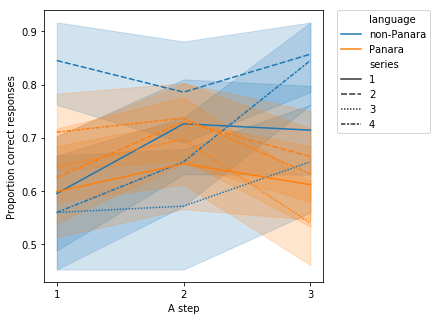

In [36]:
f, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.lineplot(x='A_time',y='match_temporal',style='series',hue='language',data=plain_agg[plain_agg.series!='5'])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axes.set(ylabel='Proportion correct responses', xlabel="A step",)
# sns.lineplot(x='A_time',y='match_temporal',hue='language',style='series',data=plain_agg[plain_agg.A_burst==False])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig = ax.get_figure()
fig.savefig('ABX3.pdf',bbox_inches='tight') 

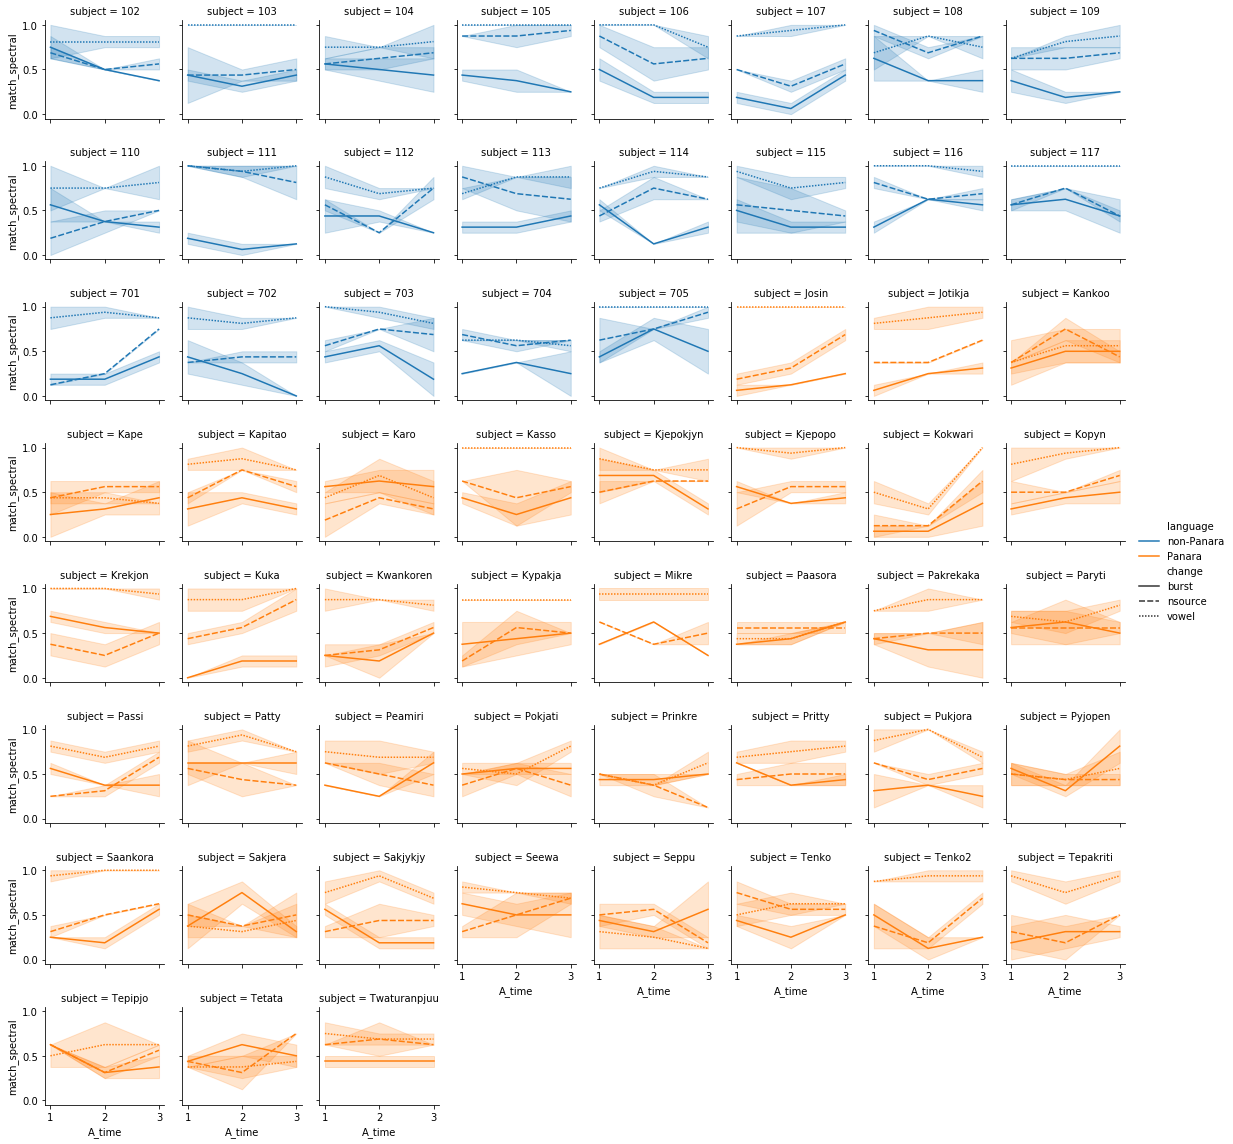

In [37]:
# f, axes = plt.subplots(1, 1, figsize=(5, 5))
# ax = sns.lineplot(x='A_time',y='match_temporal',style='series',data=plain_agg,color=sns.color_palette()[1])
# # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.axes.set(ylabel='Proportion correct responses', xlabel="A step",)
# # sns.lineplot(x='A_time',y='match_temporal',hue='language',style='series',data=plain_agg[plain_agg.A_burst==False])
# # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# fig = ax.get_figure()

g = sns.FacetGrid(vary_agg, col="subject", col_wrap=8, height=2)
g.map(sns.lineplot, "A_time", "match_spectral", data=vary_agg, hue="language",style='change')
g.add_legend();

In [38]:
plain_agg.head()

,subject,language,series,A_time,A_burst,order,response,repeats,streak1,streak0,streak,streakalt,change_vowel,change_nsource,change_burst,match_temporal,match_spectral
0,102,non-Panara,1,1,False,24.5,0.0,NaN,0.0,1.5,1.5,1.0,False,False,False,0.5,0.0
1,102,non-Panara,1,1,True,24.5,0.5,NaN,1.0,1.0,2.0,0.0,False,False,False,0.5,0.0
2,102,non-Panara,1,2,False,24.0,0.5,NaN,1.5,1.0,2.5,0.0,False,False,False,1.0,0.0
3,102,non-Panara,1,2,True,34.5,0.0,NaN,0.0,2.5,2.5,0.0,False,False,False,1.0,0.0
4,102,non-Panara,1,3,False,29.0,0.0,NaN,0.0,2.5,2.5,1.0,False,False,False,0.5,0.0


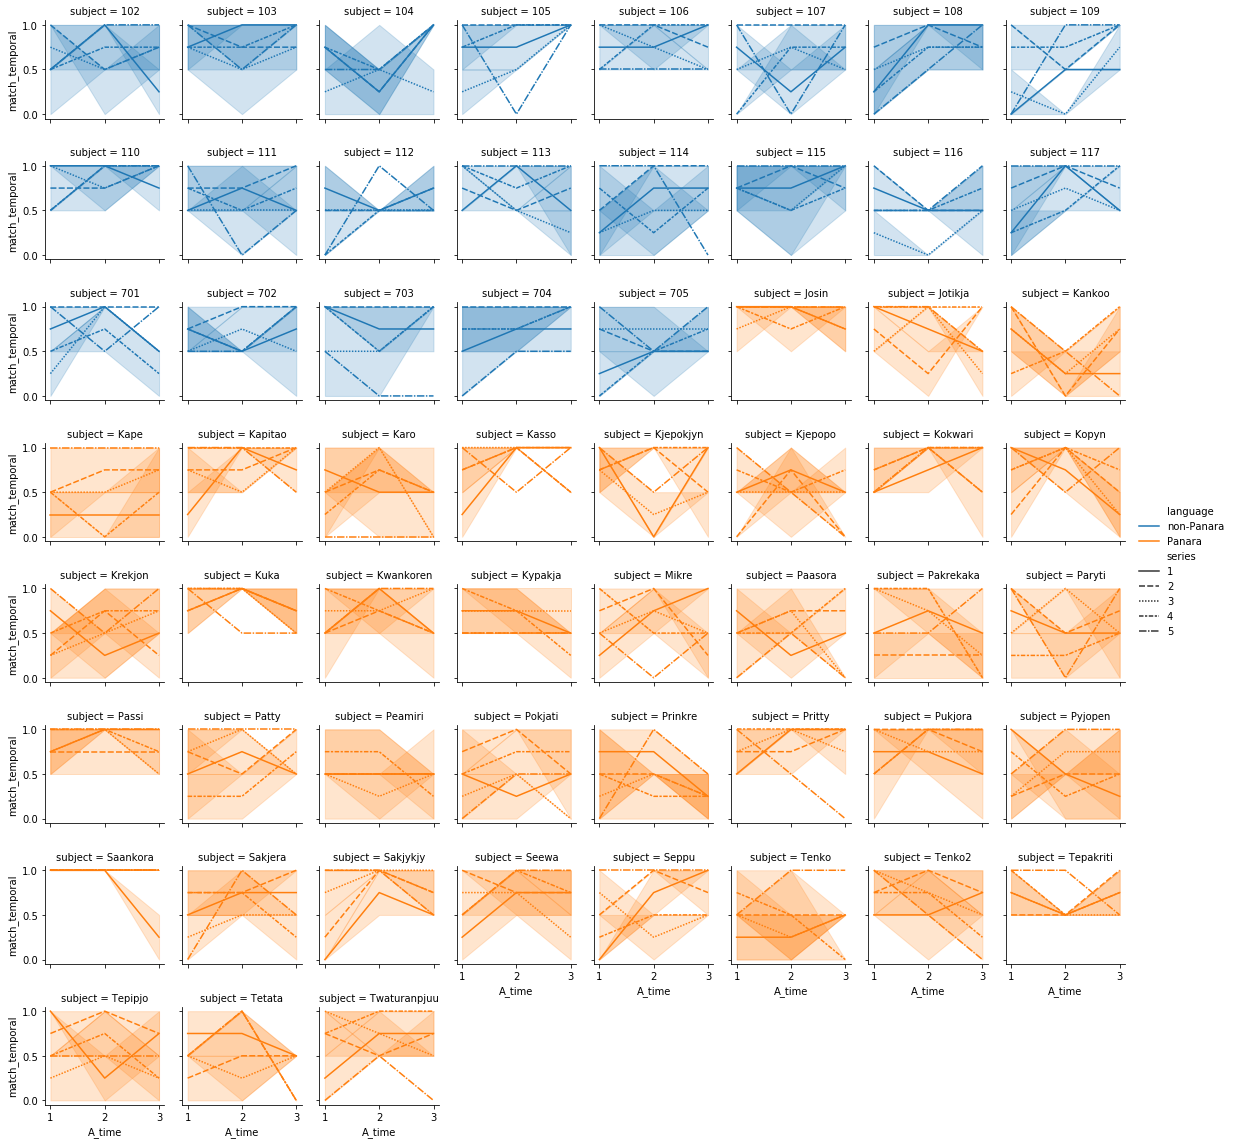

In [39]:
g = sns.FacetGrid(plain_agg, col="subject", col_wrap=8, height=2)
g.map(sns.lineplot, "A_time", "match_temporal", data=plain_agg, hue="language",style='series')
g.add_legend();